# Word and feature embeddings

In this notebook, we wish to explore and experiement with feature embeddings, more specifically word embeddings, for use in our neural classification approaches. Technologies such as word2vec and fastText have been proven to increase the effectiveness of neural models by moving from a BOW model to word and sentence relationship vector representations. The first of these we will look at is word2vec, a breakthrough 2 layer neural network algorithm patented by Google that turns a corpus of text into a vocab of word embeddings.

There are two types of this algorithm: CBOW and skip-gram. 

To do this, we will use the gensim library. We will demonstrate word2vec using our smaller corpus, OpSpam, and apply it to our Yelp datasets in the future.

## OpSpam

In [6]:
import gensim
import word_normalization as wn
from scripts import training_helpers
import numpy as np
import re

df = training_helpers.get_data_frame()
reviews = df['review'] # Gets our dataset in a Pandas data frame
labels = df['deceptive']
print(reviews.head()) 
sentences = [wn.normalize(review.split()) for review in reviews] # Tokenizes our reviews
print(sentences[1])

0    We stayed at the Schicago Hilton for 4 days an...
1    Hotel is located 1/2 mile from the train stati...
2    I made my reservation at the Hilton Chicago be...
3    When most people think Hilton, they think luxu...
4    My husband and I recently stayed stayed at the...
Name: review, dtype: object
['hotel', 'located', '12', 'mile', 'train', 'station', 'quite', 'hike', 'youre', 'traveling', 'luggage', 'andor', 'kids', 'seem', 'cash', 'guests', 'arrive', 'private', 'car', 'charging', 'exorbitant', 'parkingvalet', 'fees', 'rooms', 'feature', 'either', 'double', 'king', 'sized', 'beds', 'queen', 'beds', 'want', 'little', 'extra', 'leg', 'room', 'bed', 'price', 'jump', 'double', 'kingsized', 'stiff', 'rooms', 'kind', 'view', 'pay', 'healthy', 'surcharge']


Now, lets use word2Vec on our reviews. We set min_words = 2, so that only words that appear a minimum of twice appear, to filter out any crappy typos. Size = 100 is the dimensionality of the vectors, which was empirically found to be 100 in studies. Workers is simply how many cores to use.

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model_w2v = Word2Vec(sentences, min_count = 2, size = 100, workers = 8, sg=1)
model_w2v.save("opspam_w2v.kv")
words = model_w2v.wv.vocab

Now that we have our dataset in word vectors, let's explore the data a bit.

Let's see how many words had a minimum count of 2, firstly.

In [8]:
print(len(words))

5241


Roughly half of the words appear a minimum of twice, indicating a lot of typos and useless words.

Let's see how accurate it models word relationships. 

In [9]:
model_w2v.wv.most_similar('hilton')

[('palmer', 0.9849350452423096),
 ('hyatt', 0.9801898002624512),
 ('friend', 0.9750168323516846),
 ('travel', 0.9725649356842041),
 ('amalfi', 0.9710886478424072),
 ('regency', 0.9709162712097168),
 ('james', 0.9696003198623657),
 ('recent', 0.9687908887863159),
 ('house', 0.9682694673538208),
 ('getaway', 0.9679558873176575)]

This is really cool, as all the most related words to 'Hilton' are other names of hotels.

Let's plot a visualization of the relationships of these words using PCA.

Because our previous word2vec vector is 8000 in size, let's up the min_count to make it much smaller for visualization purposes. 

In [10]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

408


/Users/niallwalsh/miniconda3/envs/lucas/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


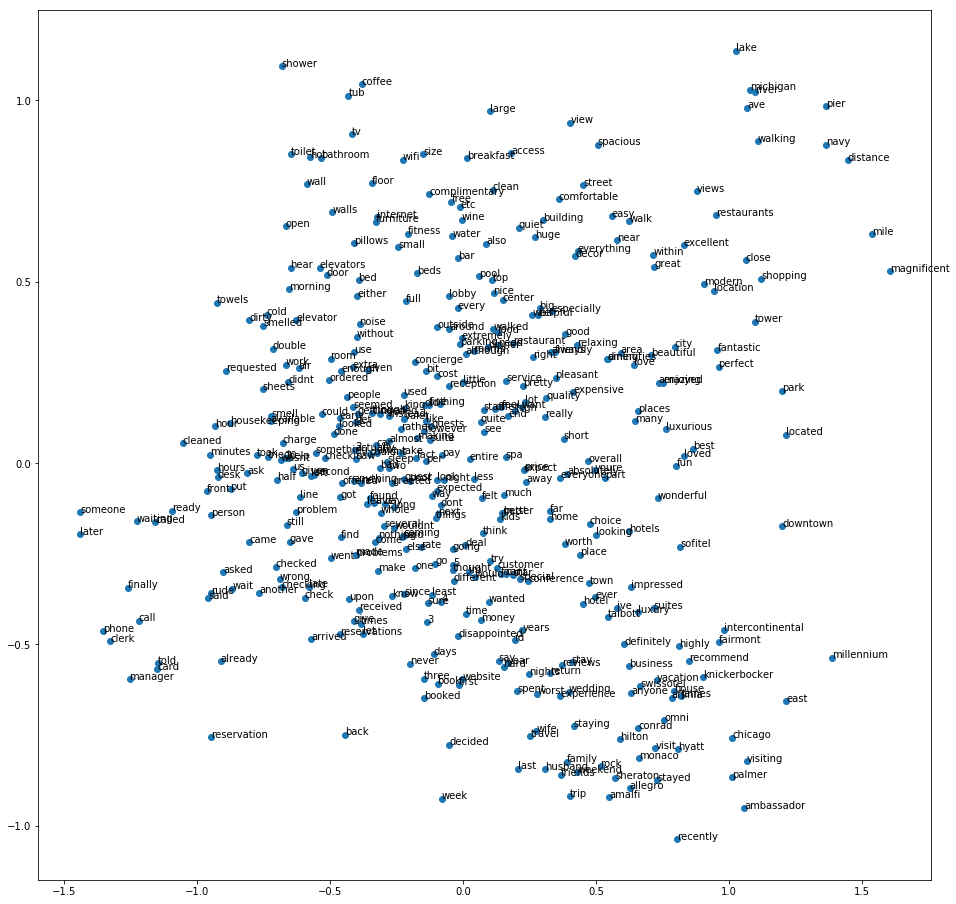

In [11]:
model_w2v = Word2Vec(sentences, min_count = 60, size = 100, workers = 8, sg=1)
words = model_w2v.wv.vocab
print(len(words))
X = model_w2v[words]

pca = PCA()

result = pca.fit_transform(X)

# create a scatter plot of the projection
figure(figsize=(16,16))
plt.scatter(result[:, 0], result[:, 1])
words = list(model_w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Now let's try Facebook's fastText.

In [12]:
from gensim.models import FastText
model_ft = FastText(sentences, size=100, min_count=3, workers=8, sg=1)
model_ft.save("opspam_ft.kv")

In [13]:
model_ft.wv.most_similar("wine")

[('drinks', 0.988455057144165),
 ('buffet', 0.9834749102592468),
 ('compliments', 0.9810757637023926),
 ('complimentary', 0.9788782596588135),
 ('drink', 0.9777003526687622),
 ('wines', 0.9756545424461365),
 ('break', 0.9731377363204956),
 ('includes', 0.9719527959823608),
 ('connect', 0.9705843925476074),
 ('coffees', 0.9692720770835876)]

Again, even on a small dataset, word embeddings are an accurate and powerful way of inferring word relationships. If we want to use this in Keras, we need to turn this into an embedding matrix to be used as input to an embedding layer in Keras. Let's see how this is done below.

In [14]:
embedding_matrix = np.zeros((len(model_ft.wv.vocab) + 1, 100))
for i in range(len(model_ft.wv.vocab)):
    embedding_vector = model_ft.wv[model_ft.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

We initialize a numpy array of zeros, the size being [1+len(vocab) x dim(embedding)].
We simply iterate through the n words in vocab and set embedding_matrix[n] = embed_vector[word[n]].
Lets take a look at what this looks like.

In [15]:
print(embedding_matrix)

[[-0.22223288 -0.3243137   0.07480421 ... -0.23490055 -0.29778469
   0.32820314]
 [-0.08246607 -0.10846302  0.14219846 ... -0.02395476 -0.56937802
   0.47441542]
 [-0.28395575 -0.47678152 -0.09881371 ... -0.17730296 -0.37889671
   0.21936527]
 ...
 [-0.13645904 -0.32550728  0.05169807 ... -0.03446067 -0.40169278
   0.21973884]
 [-0.14515314 -0.41276819  0.06310978 ... -0.14171644 -0.35654852
   0.23702967]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Now let's take a look at something similar, called Doc2Vec. Just as word2vec creates embedding vectors for individual words to map relationships, doc2vec creates embedding vectors for documents and maps relationships between them, which could also be a feature for us (cosine similarity to deceptive documents).

Below we tag all of our reviews with a number using the gensim TaggedDocument constructor.

We then train our doc2vec model over 20 epochs, diminishing the learning rate each time.

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk import word_tokenize
tagged_data = [TaggedDocument(words=word_tokenize(review.lower()), tags=[str(i)]) for i, review in enumerate(reviews)]

model = Doc2Vec(size=50,min_count=1, dm=1)
  
model.build_vocab(tagged_data)

for epoch in range(20):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("opspam_d2v.kv")
print("Model Saved")

/Users/niallwalsh/miniconda3/envs/lucas/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/niallwalsh/miniconda3/envs/lucas/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model Saved


In [17]:
model= Doc2Vec.load("opspam_d2v.kv")

# https://arxiv.org/pdf/1405.4053v2.pdf

#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('3')
print(similar_doc)
print(reviews[3], labels[3]) 
print(model.docvecs['3'])

print('\n Most similar review: ', reviews[int(similar_doc[0][0])], labels[int(similar_doc[0][0])])
print('Most similar review (vector): ', model.docvecs[similar_doc[0][0]])

V1_infer [-0.14835688 -0.18196984  0.08145543  0.22846684 -0.22250701 -0.00489206
 -0.14416698  0.080345    0.06376534  0.32511765 -0.0653161  -0.12847723
 -0.13120916  0.1181073  -0.00766151 -0.05652037  0.1012564   0.00074359
 -0.31151178 -0.09217153 -0.21401876  0.12933704  0.08986327  0.0781295
 -0.03446183 -0.11076732 -0.16676553  0.00305456  0.12989034  0.33002305
  0.1941718   0.04280426 -0.03657907 -0.03954023  0.0630489  -0.06078229
  0.14956881  0.14681321  0.11901703 -0.02714682 -0.1783937  -0.02239525
  0.00582167 -0.02466648  0.18870214 -0.06156288 -0.00224238 -0.2594095
 -0.21507722  0.07442322]
[('17', 0.6534526348114014), ('384', 0.6217939257621765), ('990', 0.5696372389793396), ('698', 0.5640696883201599), ('1305', 0.5524073243141174), ('1348', 0.548210620880127), ('320', 0.5334551334381104), ('345', 0.5286558270454407), ('657', 0.514114260673523), ('782', 0.5082442760467529)]
When most people think Hilton, they think luxury. I know I did. I only wish I'd been half rig

Now let's try word2vec over our much larger dataset, so we can use them in our neural network experiments later on.

In [18]:
from protos import review_set_pb2, review_pb2

review_set = review_set_pb2.ReviewSet()
with open("../data/normalizedData/yelpZip", 'rb') as f:
    review_set.ParseFromString(f.read())
all_reviews = list(review_set.reviews)

In [ ]:
reviews_tokenized = [wn.normalize(str(review).split()) for review in all_reviews]

In [ ]:
print(len(reviews_tokenized))

In [ ]:
model_w2v_yelp = Word2Vec(reviews_tokenized, min_count = 4, size = 100, workers = 8, sg=1)

In [ ]:
model_w2v_yelp.wv.most_similar('awful')
model_w2v_yelp.wv['hello']

This word vector embedding will be extremely useful in our neural approaches to classification in future notebooks as a much better impression of words than the typical BOW format.

Let's save this embedding model to be used later.

In [ ]:
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
fname = "yelp_w2v.kv"
model_w2v_yelp.save(fname)

Now we have our embedding vector saved as in gensim KeyedVector format, an efficient representation.

Let's quickly load this embedding back in and demonstrate again how it can be turned into an embedding matrix for Keras to use.

In [ ]:
word_vectors = KeyedVectors.load(fname, mmap='r')

In [ ]:
embedding_matrix = np.zeros((len(word_vectors.wv.vocab) + 1, 100))
for i in range(len(word_vectors.wv.vocab)):
    embedding_vector = word_vectors.wv[word_vectors.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix.shape)

Awesome. We have successfully converted our entire dataset of reviews into w2v format.
Just to have it around, let's do the same with fastText.

In [ ]:
model_ft_yelp = FastText(reviews_tokenized_clean, min_count = 8, size = 100, workers = 8, sg=1)

In [ ]:
model_ft_yelp.save('../yelp_ft.kv')

Let's see how fastText does on unseen words.

In [ ]:
model_ft_yelp.wv.most_similar('tasty')